# Denoising Diffusion Implicit Models

**Author:** [András Béres](https://www.linkedin.com/in/andras-beres-789190210)<br>
**Date created:** 2022/06/24<br>
**Last modified:** 2022/06/24<br>
**Description:** Generating images of flowers with denoising diffusion implicit models.

## Introduction

### What are diffusion models?

Recently, [denoising diffusion models](https://arxiv.org/abs/2006.11239), including
[score-based generative models](https://arxiv.org/abs/1907.05600), gained popularity as a
powerful class of generative models, that can [rival](https://arxiv.org/abs/2105.05233)
even [generative adversarial networks (GANs)](https://arxiv.org/abs/1406.2661) in image
synthesis quality. They tend to generate more diverse samples, while being stable to
train and easy to scale. Recent large diffusion models, such as
[DALL-E 2](https://openai.com/dall-e-2/) and [Imagen](https://imagen.research.google/),
have shown incredible text-to-image generation capability. One of their drawbacks is
however, that they are slower to sample from, because they require multiple forward passes
for generating an image.

Diffusion refers to the process of turning a structured signal (an image) into noise
step-by-step. By simulating diffusion, we can generate noisy images from our training
images, and can train a neural network to try to denoise them. Using the trained network
we can simulate the opposite of diffusion, reverse diffusion, which is the process of an
image emerging from noise.

![diffusion process gif](https://i.imgur.com/dipPOfa.gif)

One-sentence summary: **diffusion models are trained to denoise noisy images, and can
generate images by iteratively denoising pure noise.**

### Goal of this example

This code example intends to be a minimal but feature-complete (with a generation quality
metric) implementation of diffusion models, with modest compute requirements and
reasonable performance. My implementation choices and hyperparameter tuning were done
with these goals in mind.

Since currently the literature of diffusion models is
[mathematically quite complex](https://arxiv.org/abs/2206.00364)
with multiple theoretical frameworks
([score matching](https://arxiv.org/abs/1907.05600),
[differential equations](https://arxiv.org/abs/2011.13456),
[Markov chains](https://arxiv.org/abs/2006.11239)) and sometimes even
[conflicting notations (see Appendix C.2)](https://arxiv.org/abs/2010.02502),
it can be daunting trying to understand
them. My view of these models in this example will be that they learn to separate a
noisy image into its image and Gaussian noise components.

In this example I made effort to break down all long mathematical expressions into
digestible pieces and gave all variables explanatory names. I also included numerous
links to relevant literature to help interested readers dive deeper into the topic, in
the hope that this code example will become a good starting point for practitioners
learning about diffusion models.

In the following sections, we will implement a continuous time version of
[Denoising Diffusion Implicit Models (DDIMs)](https://arxiv.org/abs/2010.02502)
with deterministic sampling.

## Setup

In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras 
from keras import layers
import tensorflow_probability as tfp

import pandas as pd
import numpy as np

In [2]:

import sys
import os

## Hyperparameters

In [3]:
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 20  # train for at least 50 epochs for good results
image_size = 64
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 500
plot_diffusion_steps = 550

# sampling

min_signal_rate = 0.02
max_signal_rate = 0.97

# architecture
embedding_dims = 100
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size =  14164     #14164
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4



## Data pipeline

We will use the
[Oxford Flowers 102](https://www.tensorflow.org/datasets/catalog/oxford_flowers102)
dataset for
generating images of flowers, which is a diverse natural dataset containing around 8,000
images. Unfortunately the official splits are imbalanced, as most of the images are
contained in the test split. We create new splits (80% train, 20% validation) using the
[Tensorflow Datasets slicing API](https://www.tensorflow.org/datasets/splits). We apply
center crops as preprocessing, and repeat the dataset multiple times (reason given in the
next section).

In [4]:
from sklearn.preprocessing import StandardScaler
"food data"
usda_food = pd.read_csv("/kaggle/input/usda-sr-legacy-and-foundation-nutrition-for-use/usda_sr_all_foods.csv")
#usda_food = pd.read_csv(r'C:\Users\Harshitha\Desktop\usda_sr_all_foods.csv')
print(usda_food["Food Group"].unique())
usda_food = usda_food.fillna(0)
usda_food["Cereals"] = usda_food["Food Group"].apply(lambda x: 0.7 if x=="Baked Foods" else 1 if x=="Breakfast Cereals" else 1 if x=="Grains and Pasta" else 0.5 if x=="Baby Foods" else 0)
usda_food["Fruits"] = usda_food["Food Group"].apply(lambda x: 0.7 if x=="Fruits" else 0 )
usda_food["Vegetables"] = usda_food["Food Group"].apply(lambda x: 0.7 if x=="Vegetables" else 0 )
usda_food["nuts"] = usda_food["Food Group"].apply(lambda x: 0.7 if x=="Nuts and Seeds" else 0.3 if x=="Baby Foods" else 0)
usda_food["pulses"] = usda_food["Food Group"].apply(lambda x: 0.7 if x=="Beans and Lentils" else 0.3 if x=="Baby Foods" else 0 )
usda_food["dairy"] = usda_food["Food Group"].apply(lambda x: 0.7 if x=="Dairy and Egg Products" else 0 )
usda_food["non-veg"] = usda_food["Food Group"].apply(lambda x: 1 if x=="Meats" else 1 if x=="Fish" else 0 )
usda_food["processd"] = usda_food["Food Group"].apply(lambda x: 1 if x=="Beverages" else 1 if x=="Fast Foods" else 1 if x=="Soups and Sauces" else 0 )
usda_food.drop(columns=["Food Group","name","ID","200 Calorie Weight (g)","PRAL score"], inplace= True)
usda_cols = usda_food.columns.to_list()
usda_cols = ["Cereals","Vegetables","nuts","pulses","dairy","non-veg","processd"]+usda_cols[:-8]
print("cholestol"+str(usda_cols.index("Cholesterol (mg)"))+"  vita mcg"+str(usda_cols.index("Vitamin A, RAE (mcg)"))+"  vit c"+str(usda_cols.index("Vitamin C (mg)")))
usda_food = usda_food[usda_cols]
print(usda_food.head()); print(usda_food.shape);
norm = StandardScaler()
usda_norm = norm.fit(usda_food)
usda_norm = norm.transform(usda_food); print(usda_norm.shape)

['Baked Foods' 'Snacks' 'Sweets' 'Vegetables' 'American Indian'
 'Restaurant Foods' 'Beverages' 'Fats and Oils' 'Meats'
 'Dairy and Egg Products' 'Baby Foods' 'Breakfast Cereals'
 'Soups and Sauces' 'Beans and Lentils' 'Fish' 'Fruits' nan
 'Grains and Pasta' 'Nuts and Seeds' 'Prepared Meals' 'Fast Foods'
 'Spices and Herbs' 'Dairy and Egg Products ']
cholestol13  vita mcg20  vit c21
   Cereals  Vegetables  nuts  pulses  dairy  non-veg  processd  Calories  \
0      0.7         0.0   0.0     0.0    0.0        0         0     307.0   
1      0.7         0.0   0.0     0.0    0.0        0         0     330.0   
2      0.7         0.0   0.0     0.0    0.0        0         0     377.0   
3      0.7         0.0   0.0     0.0    0.0        0         0     232.0   
4      0.7         0.0   0.0     0.0    0.0        0         0     273.0   

   Fat (g)  Protein (g)  ...  Histidine (mg)  Alanine (mg)  \
0    13.24         5.88  ...             0.0           0.0   
1    11.27         4.34  ...     

In [5]:
usda_food = usda_food.sample(n=5000, replace=True)

In [5]:
from sklearn.neighbors import NearestNeighbors

kn = NearestNeighbors(n_neighbors=1).fit(usda_food)
dst, ind = kn.kneighbors(usda_food)
print(ind.shape)


(14164, 1)


In [11]:

# load dataset
#train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
#val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")
usda_food_rpt = tf.concat([usda_food, usda_food, usda_food, usda_food, usda_food,usda_food,usda_food,usda_food,usda_food,usda_food,usda_food,usda_food,usda_food], axis=0); print(usda_food_rpt.shape) ;
train_dataset = tf.cast( tf.expand_dims( usda_food_rpt, axis=1) , dtype=tf.float32);  print(train_dataset.shape)
train_size = batch_size

(65000, 100)
(65000, 1, 100)


# diffusion to normal distribution

In [ ]:
import tensorflow_addons as tfa

reg = tf.keras.regularizers.L2(0.0005)
inp= tf.keras.Input((None,100))
x = layers.Dense(100)(inp)
norm = layers.BatchNormalization()(x)
x = layers.Dense(100)(norm)
out = layers.Dense(100, activation="sigmoid")(x)


'''--***--auto encoder--***--'''
inp = tf.keras.Input((100))
inp = tf.expand_dims(inp,axis=-1)
inp = layers.BatchNormalization()(inp)
x = layers.Conv1D(50,100,padding='same',activation='leaky_relu',kernel_regularizer=reg)(inp)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(30,3,activation='leaky_relu',padding='same',kernel_regularizer=reg)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(40,5,activation='leaky_relu',padding='same', kernel_regularizer=reg)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(30,5,strides=2,activation='leaky_relu',padding='same',kernel_regularizer=reg)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(30,5,activation='leaky_relu',padding='same',kernel_regularizer=reg)(x)
x = layers.BatchNormalization()(x)
x1 = layers.Conv1D(30,5, activation='leaky_relu',padding='same',kernel_regularizer=reg)(x)
emb_m = layers.Conv1D(1,5,activation='sigmoid',padding='same')(x1)
emb_m = tf.squeeze(emb_m, axis=-1)
x2 = layers.Conv1D(30,5, activation="leaky_relu",padding='same',kernel_regularizer=reg)(x)
emb_v = layers.Conv1D(1,5,activation='sigmoid',padding='same')(x2)
emb_v =tf.squeeze(emb_v,axis=-1) 
nois = tf.random.normal(tf.shape(emb_m)) 
emb = nois * tf.exp(emb_v * 0.5) + emb_m
x = tf.expand_dims(emb,axis=-1)
w_nois =  layers.Dense(5,activation='tanh')(layers.Flatten()(inp)) #tf.random.normal([1,5])
#x = layers.Conv1D(30,50,activation='leaky_relu',padding='same',kernel_regularizer=reg)(x)
#x = layers.BatchNormalization()(x)
x = layers.Conv1DTranspose(70,5,strides=2,activation="leaky_relu",padding='same',kernel_regularizer=reg)(x)
#x = 0.25*tf.random.normal(tf.shape(x)) + 0.75*x
x = tfa.layers.InstanceNormalization()(x)
scl = layers.Dense(70,activation='leaky_relu')(w_nois)
sft = layers.Dense(70,activation='leaky_relu')(w_nois)
adn = tf.expand_dims(scl,axis=-2) + x * tf.expand_dims(sft,axis=-2)
x = layers.Conv1DTranspose(70,5,activation="leaky_relu",padding='same',kernel_regularizer=reg)(adn)
#x = 0.25*tf.random.normal(tf.shape(x)) + 0.75*x
x = tfa.layers.InstanceNormalization()(x)
scl = layers.Dense(70,activation='leaky_relu')(w_nois)
sft = layers.Dense(70,activation='leaky_relu')(w_nois)
adn = tf.expand_dims(scl,axis=-2) + x * tf.expand_dims(sft,axis=-2)
x = layers.Conv1DTranspose(50,5,activation="leaky_relu",padding='same',kernel_regularizer=reg)(adn)
#x = 0.2*tf.random.normal(tf.shape(x)) + 0.8*x
x = tfa.layers.InstanceNormalization()(x)
scl = layers.Dense(50,activation='leaky_relu')(w_nois)
sft = layers.Dense(50,activation='leaky_relu')(w_nois)
adn = tf.expand_dims(scl,axis=-2) + x * tf.expand_dims(sft,axis=-2)
x = layers.Conv1DTranspose(30,5,activation="leaky_relu",padding='same',kernel_regularizer=reg)(adn)
#x = 0.2*tf.random.normal(tf.shape(x)) + 0.8*x
x = tfa.layers.InstanceNormalization()(x)
scl = layers.Dense(30,activation='leaky_relu')(w_nois)
sft = layers.Dense(30,activation='leaky_relu')(w_nois)
adn = tf.expand_dims(scl,axis=-2) + x * tf.expand_dims(sft,axis=-2)
x = layers.Conv1DTranspose(20,5,activation="leaky_relu",padding='same',kernel_regularizer=reg)(adn)
#x = 0.2*tf.random.normal(tf.shape(x)) + 0.8*x
x = tfa.layers.InstanceNormalization()(x)
scl = layers.Dense(20,activation='leaky_relu')(w_nois)
sft = layers.Dense(20,activation='leaky_relu')(w_nois)
adn = tf.expand_dims(scl,axis=-2) + x * tf.expand_dims(sft,axis=-2)
x = layers.Conv1DTranspose(30,5,activation="leaky_relu",padding='same',kernel_regularizer=reg)(adn)
#x = 0.2*tf.random.normal(tf.shape(x)) + 0.8*x
x = tfa.layers.InstanceNormalization()(x)
scl = layers.Dense(30,activation='leaky_relu')(w_nois)
sft = layers.Dense(30,activation='leaky_relu')(w_nois)
adn = tf.expand_dims(scl,axis=-2) + x * tf.expand_dims(sft,axis=-2)
x = layers.Conv1DTranspose(50,100,activation="leaky_relu",padding='same',kernel_regularizer=reg)(adn)
#x = 0.2*tf.random.normal(tf.shape(x)) + 0.8*x
x = tfa.layers.InstanceNormalization()(x)
scl = layers.Dense(50,activation='leaky_relu')(w_nois)
sft = layers.Dense(50,activation='leaky_relu')(w_nois)
adn = tf.expand_dims(scl,axis=-2) + x * tf.expand_dims(sft,axis=-2)
x = layers.Conv1DTranspose(1,100,activation="leaky_relu",padding='same' )(adn)
#x = 0.2*tf.random.normal(tf.shape(x)) + 0.8*x
x = tfa.layers.InstanceNormalization()(x)
scl = layers.Dense(1,activation='leaky_relu')(w_nois)
sft = layers.Dense(1,activation='leaky_relu')(w_nois)
adn = tf.expand_dims(scl,axis=-2) + x * tf.expand_dims(sft,axis=-2)
out = tf.squeeze(adn,axis=-1)
#x = layers.Dense(300,activation='leaky_relu')(emb)
#x = layers.Dense(200,activation='leaky_relu')(x)
#scl_50 = layers.Dense(100,activation='sigmoid')(x)
#x = layers.Dense(300,activation='leaky_relu')(emb)
#x = layers.Dense(200,activation='leaky_relu')(x)
#scl_1000 = layers.Dense(100,activation='sigmoid')(x)
#out = out

encdr = tf.keras.Model(inp,[emb_m,emb_v])
encdec = tf.keras.Model(inp,out) ; encdec.summary()
class wlos(tf.keras.losses.Loss):
    def call(self,y_true,y_pred):
        dif = tfp.math.trapz(tf.math.abs(y_pred - y_true), axis=0)/batch_size ;
        return dif  #tf.sqrt(1+tf.square(dif))
        #recnst= tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred),axis=-1))
        #return recnst
wloso = wlos()

def get_grd(mdl,rel,nois,los):
    with tf.GradientTape() as pnlty:
         mn,vr = encdr(rel)
         kl = -0.5 *(1+vr - tf.square(mn)-tf.exp(vr))
         kl = tf.reduce_mean(tf.reduce_sum(kl,axis=-1))

    with tf.GradientTape() as grd:
        grd.watch(mdl.trainable_variables)
        fke = mdl(rel)
        lss = los(rel,fke) #lss = los.call(rel,fke)
        lss1 = lss # + kl ; #lss1 = tf.reduce_mean(lss1, axis=[0,1]) ; lss1= tf.Variable(lss1) ;print(mdl.trainable_variables[-1], lss1)
        return grd.gradient(lss1,mdl.trainable_variables) , lss
class wgn(tf.keras.Model):
    def __init__(self,mdl,rel,los,opt,grdfn):
        super().__init__()
        self.mdl = mdl; self.rel = tf.dtypes.cast(rel,tf.float32); self.los=los; self.opt= opt;
        #self.opt= tf.keras.optimizers.Adam(0.0005,beta_1=0.8,beta_2=0.88,epsilon=1e-5) 
        self.grdfn = grdfn 
    def compile(self,loss,optimizer,metrics): 
        super().compile() 
        self.mdl.compile(loss=self.los,optimizer=self.opt,metrics=["Accuracy"]) 
    def train_step(self,rl):
        rel=rl
        for i in range(2):
            with tf.GradientTape() as grdtp:
                grdtp.watch(self.mdl.trainable_variables)
                fke = self.mdl(self.rel)
                lss = self.los(self.rel,fke) #lss = los.call(rel,fke)
                lss1 = lss +1.5*(1+tf.keras.losses.cosine_similarity(self.rel,fke))**2  # + kl ; #lss1 = tf.reduce_mean(lss1, axis=[0,1]) ; lss1= tf.Variable(lss1) ;print(mdl.trainable_variables[-1], lss1)
                grd = grdtp.gradient(lss1,self.mdl.trainable_variables)
            #grd = tf.reduce_mean(grd,axis=0); print(grd)
            self.opt.apply_gradients(zip(grd,self.mdl.trainable_variables))
            #mn = tf.reduce_mean(lss) ;
            #a = tf.print(mn,[mn]," loss ")
        return {"loss":lss1,"err:":tf.keras.losses.mean_absolute_error(self.rel,fke),'cos sim: ':tf.keras.losses.cosine_similarity(self.rel,fke)}

x  = tf.expand_dims(usda_norm,axis=1) ;
opt = tf.keras.optimizers.Adam(0.0005,beta_1=0.8,beta_2=0.88,epsilon=1e-5)
wgno = wgn(encdec,usda_norm,wloso,opt,get_grd)
wgno.compile(loss=wgno.los,optimizer= opt,metrics=["Acccuracy"])
#wgno.compile(loss='mean_absolute_error',optimizer=opt,metrics=["Acccuracy"])
wgno.fit(x,epochs=5)
#encdec.compile(loss=wloso,optimizer=opt,metrics=["Accuracy"])
#encdec.fit([x,tf.random.normal(shape=x.shape)],x,epochs=10)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 100, 50)      5050        ['input_12[0][0]']               
                                                                                                  
 batch_normalization_23 (BatchN  (None, 100, 50)     200         ['conv1d_27[2][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_28 (Conv1D)             (None, 100, 30)      4530        ['batch_normalization_23[2]

In [14]:
wgno.fit(x,epochs=5) 

Epoch 1/5
443/443 [==============================] - 1261s 3s/step - loss: 0.5499 - err:: 0.2980
Epoch 2/5
297/443 [===================>..........] - ETA: 6:55 - loss: 0.5195 - err:: 0.2979

KeyboardInterrupt: 

In [ ]:
opt2 = tf.keras.optimizers.Adam(0.005 )
encdec.compile(loss=wloso,optimizer=opt2,metrics=["Accuracy"])
encdec.fit([x,tf.random.normal(shape=x.shape)],x,epochs=10)

Epoch 1/10

63/63 [==============================] - 10s 76ms/step - loss: 97.7512 - Accuracy: 0.2650

Epoch 2/10

63/63 [==============================] - 5s 75ms/step - loss: 97.3482 - Accuracy: 0.2685

Epoch 3/10

63/63 [==============================] - 5s 76ms/step - loss: 95.8155 - Accuracy: 0.2665

Epoch 4/10

63/63 [==============================] - 5s 73ms/step - loss: 94.9290 - Accuracy: 0.2525

Epoch 5/10

63/63 [==============================] - 5s 74ms/step - loss: 94.2848 - Accuracy: 0.2600

Epoch 6/10

63/63 [==============================] - 5s 75ms/step - loss: 96.0423 - Accuracy: 0.2660

Epoch 7/10

63/63 [==============================] - 5s 79ms/step - loss: 95.6294 - Accuracy: 0.2625

Epoch 8/10

63/63 [==============================] - 5s 81ms/step - loss: 94.5930 - Accuracy: 0.2655

Epoch 9/10

63/63 [==============================] - 5s 80ms/step - loss: 94.9296 - Accuracy: 0.2610

Epoch 10/10

63/63 [==============================] - 5s 82ms/step - loss: 96.004

In [ ]:
xt = x[25:30,:,:]
yt = wgno.mdl.predict([x,tf.random.normal(shape=x.shape)]) ; print(tf.reduce_mean(tf.reduce_sum(tf.abs(yt-x),axis=-1),axis=0))
yt = wgno.mdl.predict([xt,tf.random.normal(shape=xt.shape)]) ; print(tf.reduce_sum(tf.abs(yt-xt),axis=-1))

63/63 [==============================] - 0s 5ms/step

tf.Tensor([11616.66025274], shape=(1,), dtype=float64)

1/1 [==============================] - 0s 22ms/step

tf.Tensor(

[[5702.21669407]

 [4760.57576509]

 [1299.08642716]

 [3247.05267033]

 [5077.49406188]], shape=(5, 1), dtype=float64)


In [ ]:
# wgan training

class wlos(tf.keras.losses.Loss):
    def call(self,y_true,y_pred):
        dif = tf.reduce_sum(tf.math.abs(y_pred - y_true), axis=-1) ;
        return tf.sqrt(1+tf.square(dif))
        #recnst= tf.reduce_mean((tf.keras.losses.binary_crossentropy(y_true,y_pred)))
        #return recnst
wloso = wlos()

def get_grd(mdl,rel,nois,los):
    with tf.GradientTape() as pnlty:
        fke = mdl([rel,nois],training=True)
        mxd = rel*0.45 + fke*0.55
        pnlty.watch(mxd)
        prd = mdl([mxd,nois],training=True)
        dff = pnlty.gradient(tf.abs(prd-mxd),mxd) ;
        penty = tf.reduce_mean(dff,axis=0) ;

    with tf.GradientTape() as grd:
        grd.watch(mdl.trainable_variables)
        fke = mdl([rel,nois])
        lss = los(rel,fke) #lss = los.call(rel,fke)
        lss1 = lss  # + dff ; #lss1 = tf.reduce_mean(lss1, axis=[0,1]) ; lss1= tf.Variable(lss1) ;print(mdl.trainable_variables[-1], lss1)
        return grd.gradient(lss1,mdl.trainable_variables) , lss
class wgn(tf.keras.Model):
    def __init__(self,mdl,rel,los,opt,grdfn):
        super().__init__()
        self.mdl = mdl; self.rel = tf.dtypes.cast(rel,tf.float32); self.los=los; self.opt= opt;
        self.opt= tf.keras.optimizers.Adam(0.01,beta_1=0.8,beta_2=0.88,epsilon=1e-5)
        self.grdfn = grdfn
   # def compile(self):
    #    super().compile()
        #self.mdl.compile(loss=self.los,optimizer=self.opt,metrics=["Accuracy"])
    def train_step(self,rl):
        rel=rl
        nois = tf.random.normal(shape=self.rel.shape)
        for i in range(2):
            grd, lss = self.grdfn(self.mdl,self.rel,nois,self.los) ;
            #grd = tf.reduce_mean(grd,axis=0); print(grd)
            self.opt.apply_gradients(zip(grd,self.mdl.trainable_variables))
            mn = tf.reduce_mean(lss) ;
            #a = tf.print(mn,[mn]," loss ")
        return {"loss":mn}

x  = tf.expand_dims(usda_food,axis=1) ;
wgno = wgn(encdec,x,wloso,opt,get_grd)
wgno.compile(loss=wgno.los,optimizer=wgno.opt,metrics=["Acccuracy"])
wgno.fit(x,epochs=5)

## Network architecture

Here we specify the architecture of the neural network that we will use for denoising. We
build a [U-Net](https://arxiv.org/abs/1505.04597) with identical input and output
dimensions. U-Net is a popular semantic segmentation architecture, whose main idea is
that it progressively downsamples and then upsamples its input image, and adds skip
connections between layers having the same resolution. These help with gradient flow and
avoid introducing a representation bottleneck, unlike usual
[autoencoders](https://www.deeplearningbook.org/contents/autoencoders.html). Based on
this, one can view
[diffusion models as denoising autoencoders](https://benanne.github.io/2022/01/31/diffusion.html)
without a bottleneck.

The network takes two inputs, the noisy images and the variances of their noise
components. The latter is required since denoising a signal requires different operations
at different levels of noise. We transform the noise variances using sinusoidal
embeddings, similarly to positional encodings used both in
[transformers](https://arxiv.org/abs/1706.03762) and
[NeRF](https://arxiv.org/abs/2003.08934). This helps the network to be
[highly sensitive](https://arxiv.org/abs/2006.10739) to the noise level, which is
crucial for good performance. We implement sinusoidal embeddings using a
[Lambda layer](https://keras.io/api/layers/core_layers/lambda/).

Some other considerations:

* We build the network using the
[Keras Functional API](https://keras.io/guides/functional_api/), and use
[closures](https://twitter.com/fchollet/status/1441927912836321280) to build blocks of
layers in a consistent style.
* [Diffusion models](https://arxiv.org/abs/2006.11239) embed the index of the timestep of
the diffusion process instead of the noise variance, while
[score-based models (Table 1)](https://arxiv.org/abs/2206.00364)
usually use some function of the noise level. I
prefer the latter so that we can change the sampling schedule at inference time, without
retraining the network.
* [Diffusion models](https://arxiv.org/abs/2006.11239) input the embedding to each
convolution block separately. We only input it at the start of the network for
simplicity, which in my experience barely decreases performance, because the skip and
residual connections help the information propagate through the network properly.
* In the literature it is common to use
[attention layers](https://keras.io/api/layers/attention_layers/multi_head_attention/)
at lower resolutions for better global coherence. I omitted it for simplicity.
* We disable the learnable center and scale parameters of the batch normalization layers,
since the following convolution layers make them redundant.
* We initialize the last convolution's kernel to all zeros as a good practice, making the
network predict only zeros after initialization, which is the mean of its targets. This
will improve behaviour at the start of training and make the mean squared error loss
start at exactly 1.

In [9]:
"""def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            100 // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies ; # print("ang_spd", angular_speeds.shape , "  x" , x.shape)
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=2
    ) ;        print("emb ", tf.sin(angular_speeds*x))
    return embeddings
sinusoidal_embedding(tf.constant([[[0.01],[0.25],[0.81]]]))"""

'def sinusoidal_embedding(x):\n    embedding_min_frequency = 1.0\n    frequencies = tf.exp(\n        tf.linspace(\n            tf.math.log(1.0),\n            tf.math.log(1000.0),\n            100 // 2,\n        )\n    )\n    angular_speeds = 2.0 * math.pi * frequencies ; # print("ang_spd", angular_speeds.shape , "  x" , x.shape)\n    embeddings = tf.concat(\n        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=2\n    ) ;        print("emb ", tf.sin(angular_speeds*x))\n    return embeddings\nsinusoidal_embedding(tf.constant([[[0.01],[0.25],[0.81]]]))'

In [6]:

def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies ; # print("ang_spd", angular_speeds.shape , "  x" , x.shape)
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=2
    ) ;        # print("emb ", tf.sin(angular_speeds*x))
    return embeddings


def ResidualBlock(width):
    def apply(x):

        residual = layers.Dense(300)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Dense(400  )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense( 300 )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense( 300 )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
          pass
        x = ResidualBlock(width)(x)
        skips.append(x)
        #x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.Dense( 300  )(x)
        for _ in range(block_depth):
          pass
        x = layers.Concatenate()([x, skips.pop()])
        x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(None,embedding_dims ))
    noise_variances = keras.Input(shape=( None, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.Dense(300)(e)
    #e = layers.BatchNormalization()(e)

    x = layers.Dense(300)(noisy_images)
    #x = layers.BatchNormalization()(x)
    x = layers.Concatenate()([x, e])

    scl_nw = layers.BatchNormalization()(noisy_images)
    scl_nw = layers.Dense(300)(scl_nw)
    scl_nw = layers.BatchNormalization()(scl_nw)
    scl_nw = layers.Dense(200)(scl_nw)
    scl_nw = layers.BatchNormalization()(scl_nw)

    skips = []

    x = DownBlock(widths, block_depth)([x, skips])

    for _ in range(block_depth):
      pass
    x = ResidualBlock(widths[-1])(x)


    x = UpBlock(widths, block_depth)([x, skips])

    x = layers.Dense( 100 , activation="relu" )(x)

    sc10 = layers.Dense(100, activation="sigmoid")(scl_nw)
    sc50 = layers.Dense(100, activation = "sigmoid")(scl_nw)
    sc100 = layers.Dense(100, activation="sigmoid")(scl_nw)
    sc500 = layers.Dense(100, activation="sigmoid")(scl_nw)
    sc1000 = layers.Dense(100, activation="sigmoid")(scl_nw)

   # x = x*sc10 + x*sc50 + x*sc100 + x*sc500 + x*sc1000

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")
'''
def get_mdl():
  reg = tf.keras.regularizers.L2(0.000001)
  inp = tf.keras.Input((None,embedding_dims))
  inp_noise = tf.keras.Input((None,1))
  #e = tf.keras.layers.Lambda(sinusoidal_embedding)(inp_noise)
  #inp = tf.keras.layers.Concatenate()([inp_emb, e])
  #inp = tf.keras.layers.BatchNormalization()(inp)
  
  xr = tf.keras.layers.Dense(200, activation="leaky_relu", kernel_regularizer=reg)(inp_noise)
  xr= tf.keras.layers.BatchNormalization()(xr)
  xr = tf.keras.layers.Dense(100, activation="leaky_relu", kernel_regularizer=reg)(xr)
  xr= tf.keras.layers.BatchNormalization()(xr) 
  #rat= tf.keras.layers.Dense(1,activation="sigmoid")(xr)
  x1 = tf.keras.layers.Concatenate()([inp,xr])
  x1 = tf.keras.layers.Dense(800, activation="leaky_relu", kernel_regularizer=reg)(x1)
  x1= tf.keras.layers.BatchNormalization()(x1)
  x2 = tf.keras.layers.Dense(800, activation="leaky_relu", kernel_regularizer=reg)(x1)
  x2= tf.keras.layers.BatchNormalization()(x2)
  x3 = tf.keras.layers.Dense(800, activation="leaky_relu", kernel_regularizer=reg)(x2)
  x3= tf.keras.layers.BatchNormalization()(x3)
  x = tf.keras.layers.Concatenate()([x3,x1])
  x = tf.keras.layers.Dense(500,activation="leaky_relu", kernel_regularizer=reg)(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(500,activation="leaky_relu", kernel_regularizer=reg)(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(500,activation="leaky_relu", kernel_regularizer=reg)(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(100, activation="tanh", kernel_regularizer=reg)(x)

  return tf.keras.Model([inp,inp_noise],x)
'''
def get_mdl():
  reg = tf.keras.regularizers.L2(0.0001)
  inp = tf.keras.Input((embedding_dims))
  noise_rate = tf.keras.Input((1))
  xr = tf.repeat(noise_rate,repeats=embedding_dims,axis=-1)
  #e = tf.keras.layers.Lambda(sinusoidal_embedding)(inp_noise)
  #inp = tf.keras.layers.Concatenate()([inp_emb, e])
  #inp = tf.keras.layers.BatchNormalization()(inp)
  
  #xr = tf.keras.layers.Dense(500, activation="leaky_relu", kernel_regularizer=reg)(inp_noise)
  #xr= tf.keras.layers.BatchNormalization()(xr) 
  #rat= tf.keras.layers.Dense(1,activation="sigmoid")(xr)
  #xa1 = tf.keras.layers.Concatenate()([inp,xr])
  xa1 = tf.stack([inp,xr],axis=-1)
  xa1 = tf.keras.layers.Conv1D(20,4,padding='valid',activation="leaky_relu")(xa1)
  xa1= tf.keras.layers.BatchNormalization()(xa1)
  xa2 = tf.keras.layers.Conv1D(40,5,padding='valid',activation="leaky_relu")(xa1)
  xa2= tf.keras.layers.BatchNormalization()(xa2)
  xa3 = tf.keras.layers.Conv1D(60,5,padding='valid',activation="leaky_relu")(xa2)
  xa3= tf.keras.layers.BatchNormalization()(xa3)
  xa4 = tf.keras.layers.Conv1D(80,5,padding='valid',activation="leaky_relu")(xa3)
  xa4= tf.keras.layers.BatchNormalization()(xa4)
  xa5 = tf.keras.layers.Conv1D(100,7,padding='valid',activation="leaky_relu")(xa4)
  xa5= tf.keras.layers.BatchNormalization()(xa5)
  #xa6 = tf.keras.layers.Conv1D(5,25,padding='valid')(xa1)
  #x = tf.keras.layers.Concatenate()([xa1,xa2,xa3,xa4,xa5,xa6])
  x = tf.keras.layers.Conv1DTranspose(100,7,activation="leaky_relu")(xa5)
  x= tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Concatenate()([x,xa4])
  x = tf.keras.layers.Conv1DTranspose(80,5,activation="leaky_relu")(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Concatenate()([x,xa3])
  x = tf.keras.layers.Conv1DTranspose(60,5,activation="leaky_relu")(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Concatenate()([x,xa2])
  x = tf.keras.layers.Conv1DTranspose(40,5, activation="leaky_relu")(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Concatenate()([x,xa1])
  #x = tf.keras.layers.Dense(1,activation="leaky_relu", kernel_regularizer=reg)(x)
  #x= tf.keras.layers.BatchNormalization()(x)
  
  x = tf.keras.layers.Conv1DTranspose(1,4,padding='valid', activation="tanh", kernel_regularizer=reg)(x)
  x = tf.squeeze(x,axis=-1)
    
  return tf.keras.Model([inp,noise_rate],x)

This showcases the power of the Functional API. Note how we built a relatively complex
U-Net with skip connections, residual blocks, multiple inputs, and sinusoidal embeddings
in 80 lines of code!

## Diffusion model

### Diffusion schedule

Let us say, that a diffusion process starts at time = 0, and ends at time = 1. This
variable will be called diffusion time, and can be either discrete (common in diffusion
models) or continuous (common in score-based models). I choose the latter, so that the
number of sampling steps can be changed at inference time.

We need to have a function that tells us at each point in the diffusion process the noise
levels and signal levels of the noisy image corresponding to the actual diffusion time.
This will be called the diffusion schedule (see `diffusion_schedule()`).

This schedule outputs two quantities: the `noise_rate` and the `signal_rate`
(corresponding to sqrt(1 - alpha) and sqrt(alpha) in the DDIM paper, respectively). We
generate the noisy image by weighting the random noise and the training image by their
corresponding rates and adding them together.

Since the (standard normal) random noises and the (normalized) images both have zero mean
and unit variance, the noise rate and signal rate can be interpreted as the standard
deviation of their components in the noisy image, while the squares of their rates can be
interpreted as their variance (or their power in the signal processing sense). The rates
will always be set so that their squared sum is 1, meaning that the noisy images will
always have unit variance, just like its unscaled components.

We will use a simplified, continuous version of the
[cosine schedule (Section 3.2)](https://arxiv.org/abs/2102.09672),
that is quite commonly used in the literature.
This schedule is symmetric, slow towards the start and end of the diffusion process, and
it also has a nice geometric interpretation, using the
[trigonometric properties of the unit circle](https://en.wikipedia.org/wiki/Unit_circle#/media/File:Circle-trig6.svg):

![diffusion schedule gif](https://i.imgur.com/JW9W0fA.gif)

### Training process

The training procedure (see `train_step()` and `denoise()`) of denoising diffusion models
is the following: we sample random diffusion times uniformly, and mix the training images
with random gaussian noises at rates corresponding to the diffusion times. Then, we train
the model to separate the noisy image to its two components.

Usually, the neural network is trained to predict the unscaled noise component, from
which the predicted image component can be calculated using the signal and noise rates.
Pixelwise
[mean squared error](https://keras.io/api/losses/regression_losses/#mean_squared_error-function) should
be used theoretically, however I recommend using
[mean absolute error](https://keras.io/api/losses/regression_losses/#mean_absolute_error-function)
instead (similarly to
[this](https://github.com/lucidrains/denoising-diffusion-pytorch/blob/master/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L371)
implementation), which produces better results on this dataset.

### Sampling (reverse diffusion)

When sampling (see `reverse_diffusion()`), at each step we take the previous estimate of
the noisy image and separate it into image and noise using our network. Then we recombine
these components using the signal and noise rate of the following step.

Though a similar view is shown in
[Equation 12 of DDIMs](https://arxiv.org/abs/2010.02502), I believe the above explanation
of the sampling equation is not widely known.

This example only implements the deterministic sampling procedure from DDIM, which
corresponds to *eta = 0* in the paper. One can also use stochastic sampling (in which
case the model becomes a
[Denoising Diffusion Probabilistic Model (DDPM)](https://arxiv.org/abs/2006.11239)),
where a part of the predicted noise is
replaced with the same or larger amount of random noise
([see Equation 16 and below](https://arxiv.org/abs/2010.02502)).

Stochastic sampling can be used without retraining the network (since both models are
trained the same way), and it can improve sample quality, while on the other hand
requiring more sampling steps usually.

In [38]:

class DiffusionModel(keras.Model):
    def __init__(self, norm, mdl):
        super().__init__()
        self.norm = norm
        self.normalizer = layers.Normalization()
        self.network = mdl
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        #self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        # images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return images

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)          #cos(90-theta) = sin(theta)  interpolated = x.signal + (1-x)noise  ; sin cos for smoothing continuos func
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1
        #print(noise_rates.shape, signal_rates)
        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        #print(noisy_images.shape, noise_rates.shape); # print(network.summary())
        # predict noise component and calculate the image component using it
        pred_noises,pred_rates = network([noisy_images, noise_rates**2], training=training)
        pred_images =   (noisy_images - pred_rates * pred_noises) / signal_rates

        return pred_noises, pred_images, pred_rates

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        if num_images == None:
          num_images= batch_size
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images, pred_rates = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=tf.random.normal(shape=(5, 1,100)) ):
        # noise -> images -> denormalized images
        if num_images == -1 :
          num_images = batch_size
        else:
          initial_noise = tf.random.normal(shape=(num_images, 1,embedding_dims))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        #images = self.normalizer(images, training=True) ; #print(images.shape)
        images = tf.reshape(images,shape=(batch_size,1,embedding_dims))
        noises = tf.random.normal(shape=(batch_size, 1, embedding_dims) )     #(batch_size, 1, 100))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        #print(noise_rates, noises.shape, images.shape); # print("sgn rte",signal_rates,"  imge",images.shape,"  noise",noises.shape)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images, pred_rates = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric
            

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))  ;

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        print("nois loss",noise_loss,"    img loss",image_loss)
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, 1, embedding_dims))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1), minval=0.0, maxval=1.0             #(batch_size,1,1)
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        #self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )
"""
        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
"""

'\n        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))\n        for row in range(num_rows):\n            for col in range(num_cols):\n                index = row * num_cols + col\n                plt.subplot(num_rows, num_cols, index + 1)\n                plt.imshow(generated_images[index])\n                plt.axis("off")\n        plt.tight_layout()\n        plt.show()\n        plt.close()\n'

diffusion model

In [28]:
import tensorflow_probability as tfp
class DiffusionModel(keras.Model):
    def __init__(self, norm, mdl):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = mdl
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        #self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        # images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return images

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)          #cos(90-theta) = sin(theta)  interpolated = x.signal + (1-x)noise  ; sin cos for smoothing continuos func
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1
        #print(noise_rates.shape, signal_rates)
        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        #print(noisy_images.shape, noise_rates.shape); # print(network.summary())
        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates], training=training)
        pred_images =   (noisy_images - noise_rates * pred_noises) / (1-signal_rates)

        return pred_noises, pred_images, noise_rates

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        if num_images == None:
          num_images= batch_size
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images,  1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images, pred_rates = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = ( next_signal_rates * pred_images + next_noise_rates * pred_noises )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=tf.random.normal(shape=(5, 1,100)) ):
        # noise -> images -> denormalized images
        if num_images == -1 :
          num_images = batch_size
        else:
          initial_noise = tf.random.normal(shape=(num_images, 1,embedding_dims))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        #images = self.normalizer(images, training=True) ; #
        batch_size = images.shape[0]
        images = tf.reshape(images,shape=(images.shape[0],embedding_dims))
        noises = tf.random.normal(shape=(images.shape[0],  embedding_dims) )     #(batch_size, 1, 100))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size,  1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        #print(noise_rates, noises.shape, images.shape); # print("sgn rte",signal_rates,"  imge",images.shape,"  noise",noises.shape)
        # mix the images with noises accordingly
        
                
        with tf.GradientTape(persistent=True) as tape:
            with tf.GradientTape() as g2:
                with tf.GradientTape() as g3:
                    noisy_images = signal_rates * images + noise_rates * noises
                    # train the network to separate noisy images to their components
                    pred_noises, pred_images, pred_rates = self.denoise(
                        noisy_images, noise_rates, signal_rates, training=True
                    )
                    noise_loss = tf.math.abs(noises-pred_noises)#self.loss(noises, pred_noises)  # used for training
                    image_loss = tf.keras.losses.MAE(images, pred_images)  # only used as metric
                    rate_loss = tf.keras.losses.CosineSimilarity(axis=0)(images,pred_images); print(rate_loss.shape)
        
                    loss_gp = tfp.math.trapz(noise_loss,axis=0)/batch_size + rate_loss  # + 0.0005*tfp.math.trapz(noise_loss,axis=0) #+ 0.5* tf.math.sqrt(0.1+tf.math.square(image_loss))#+0.01*(tf.math.sqrt(0.1+tf.math.square(rate_loss))) ; print(loss_gp)
                    #gradients = tape.gradient(loss_gp, self.network.trainable_weights); # print(noise_loss.shape,gradients)
                    #grd2 = g2.gradient(gradients,self.network.trainable_weights)
                    #grd3 = g3.gradient(grd2, self.network.trainable_weights)
                    #loss_gp = noise_loss + 0.00001*tf.math.sqrt(1+ tf.math.square(grd3[-1]))
                    gradients= tape.gradient(loss_gp,self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights)) ; 

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights 
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        print("nois loss",noise_loss,"    img loss",image_loss)
        return {"noise":noise_loss, "img loss":image_loss, "gp":loss_gp,"kl":rate_loss} #{m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, 1, embedding_dims))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1), minval=0.0, maxval=1.0             #(batch_size,1,1)
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images, pred_rates = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = tf.keras.losses.MAE(images, pred_images)
        rate_loss = self.loss(noise_rates,pred_rates)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        #images = self.denormalize(images)
        #generated_images = self.generate(
        #    num_images=batch_size, diffusion_steps=kid_diffusion_steps
        # )
        #self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )
"""
        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
"""

'\n        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))\n        for row in range(num_rows):\n            for col in range(num_cols):\n                index = row * num_cols + col\n                plt.subplot(num_rows, num_cols, index + 1)\n                plt.imshow(generated_images[index])\n                plt.axis("off")\n        plt.tight_layout()\n        plt.show()\n        plt.close()\n'

In [16]:
np.mean(usda_food_rpt,axis=0)

array([1.0758000e-01, 1.1228000e-01, 2.0820000e-02, 3.5660000e-02,
       1.4980000e-02, 2.8760000e-01, 1.2240000e-01, 1.9441840e+02,
       9.3271180e+00, 1.0323824e+01, 1.7719958e+01, 5.3067820e+00,
       1.8247800e+00, 3.8627800e+01, 2.9806528e+00, 6.8729800e+01,
       1.9997400e+00, 2.5448020e+02, 3.0217200e+01, 3.6917060e+02,
       8.4069600e+01, 6.8122400e+00, 9.4943600e-01, 4.5140000e-01,
       8.9576000e-01, 0.0000000e+00, 1.5895178e+01, 6.0915456e+01,
       1.6161160e+02, 1.6207972e+03, 9.6768000e-02, 0.0000000e+00,
       0.0000000e+00, 3.2024800e-01, 1.5603200e-01, 1.5581600e-01,
       7.2920000e-02, 3.3784000e-02, 2.8280000e-03, 1.3041040e+00,
       0.0000000e+00, 1.4026560e+02, 3.0458880e+02, 1.6612280e+00,
       1.5563400e-01, 2.6678460e-01, 1.3448500e+01, 1.1423200e+00,
       0.0000000e+00, 0.0000000e+00, 1.6490600e-01, 1.9669120e-01,
       2.8136510e+00, 2.8781600e-01, 2.1915220e-01, 0.0000000e+00,
       3.7102600e+01, 1.4324000e+01, 2.1868400e+01, 4.5740800e

In [29]:

from sklearn.preprocessing import StandardScaler
class rmsl(tf.keras.losses.Loss):
    def __init__(self):
        pass
    def call(self,ytrue,ypred):
        return tf.math.sqrt(1+tf.math.square(ytrue-ypred))
los = rmsl()
opt = tf.keras.optimizers.Adam(0.0002)  
los = tf.keras.losses.mean_squared_error
batch_size= usda_food.shape[0]
norm = StandardScaler()
usda_norm = norm.fit(usda_food)
usda_norm = norm.transform(usda_food); print(usda_norm.shape)
mdl = get_mdl()
dff = DiffusionModel(norm, mdl)
dff.compile(optimizer=opt,loss=los,metrics=["Accuracy"])
dff.fit(usda_norm,epochs=10, batch_size=batch_size)


(14164, 100)
Epoch 1/10
()
nois loss Tensor("Abs:0", shape=(14164, 100), dtype=float32)     img loss Tensor("Mean:0", shape=(14164,), dtype=float32)
()
nois loss Tensor("Abs:0", shape=(14164, 100), dtype=float32)     img loss Tensor("Mean:0", shape=(14164,), dtype=float32)
1/1 [==============================] - 58s 58s/step - noise: 1.0845 - img loss: 3.5543 - gp: 1.1744 - kl: -0.4705
Epoch 2/10
1/1 [==============================] - 46s 46s/step - noise: 0.9129 - img loss: 3.1386 - gp: 1.0887 - kl: -0.4840
Epoch 3/10
1/1 [==============================] - 46s 46s/step - noise: 0.7577 - img loss: 2.6855 - gp: 1.0410 - kl: -0.4794
Epoch 4/10
1/1 [==============================] - 45s 45s/step - noise: 0.6552 - img loss: 2.4784 - gp: 1.0198 - kl: -0.4858
Epoch 5/10
1/1 [==============================] - 46s 46s/step - noise: 0.5975 - img loss: 2.3446 - gp: 1.0118 - kl: -0.4991
Epoch 6/10
1/1 [==============================] - 46s 46s/step - noise: 0.5704 - img loss: 2.3007 - gp: 1.0098 -

In [ ]:
opt = tf.keras.optimizers.Adam(0.001) 

dff.compile(optimizer=opt,loss=los,metrics=["Accuracy"]) 

hist = dff.fit(usda_norm,epochs=150, batch_size=batch_size) 

Epoch 1/150
()
nois loss Tensor("Abs:0", shape=(14164, 100), dtype=float32)     img loss Tensor("Mean:0", shape=(14164,), dtype=float32)
()
nois loss Tensor("Abs:0", shape=(14164, 100), dtype=float32)     img loss Tensor("Mean:0", shape=(14164,), dtype=float32)
1/1 [==============================] - 56s 56s/step - noise: 0.5212 - img loss: 2.2854 - gp: 1.0024 - kl: -0.4984
Epoch 2/150
1/1 [==============================] - 48s 48s/step - noise: 0.5044 - img loss: 2.1822 - gp: 1.0020 - kl: -0.5113
Epoch 3/150
1/1 [==============================] - 48s 48s/step - noise: 0.5711 - img loss: 2.6152 - gp: 1.0042 - kl: -0.4895
Epoch 4/150
1/1 [==============================] - 48s 48s/step - noise: 0.5242 - img loss: 2.3329 - gp: 1.0017 - kl: -0.4936
Epoch 5/150
1/1 [==============================] - 56s 56s/step - noise: 0.5004 - img loss: 2.1240 - gp: 1.0017 - kl: -0.5010
Epoch 6/150
1/1 [==============================] - 81s 81s/step - noise: 0.4990 - img loss: 2.0150 - gp: 1.0018 - kl: -0

In [18]:
dff.save_weights('unetdiffwgts.h5') 

ValueError: Unable to create group (name already exists)

(14164,)


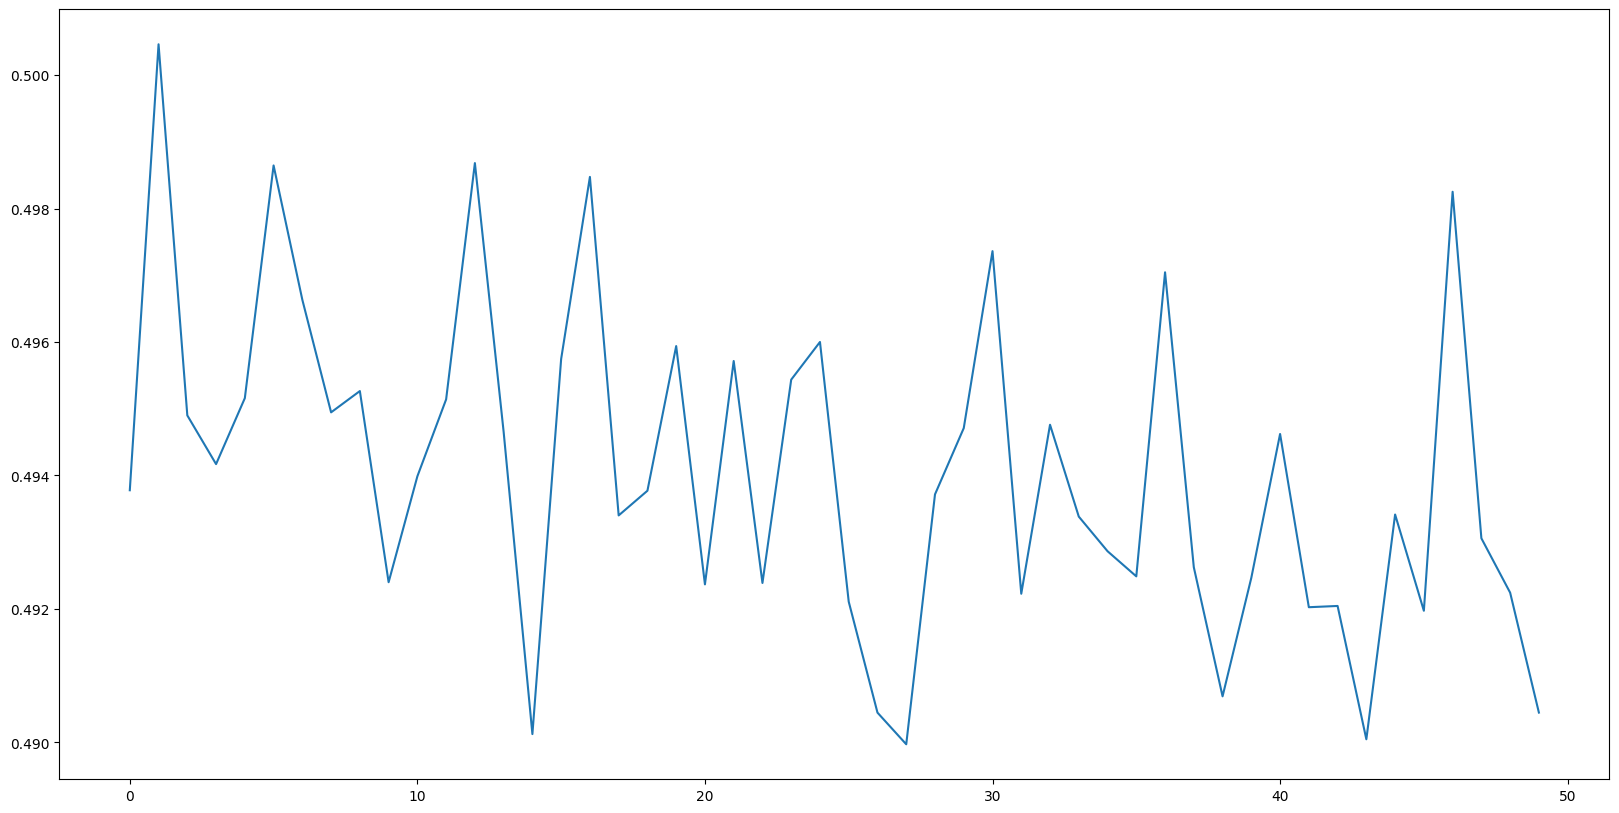

In [14]:
import matplotlib.pyplot as plt

print(np.mean(np.array(hist.history["gp"]),axis=0).shape)
fig = plt.figure(figsize=(20,10))
plt.plot(np.mean(np.array(hist.history["gp"]),axis=-1))

In [68]:
tst_sz = 150
nos = tf.random.normal((tst_sz,1,100))
rat= tf.random.normal((tst_sz,1,1),mean=0.9,stddev=0.05)
pred_nois = dff.network.predict([nos,tf.random.normal((tst_sz,1,1),mean=0.9,stddev=0.05)])
img = (nos - pred_nois * rat)/ (1-rat+0.1) #tf.sin(tf.acos(rat))
img_org = norm.inverse_transform(tf.squeeze(img))
dst,ind = kn.kneighbors(img_org)
print(np.mean(dst));   # print(dst,ind)
for i in range(5):
  pred_nois = dff.network.predict([nos,tf.random.normal((tst_sz,1,1),mean=(450-i)/500,stddev=0.05)])
  img = (nos - pred_nois * (450-i)/500)/(1-(450-i)/500 +0.1)   # tf.sin(tf.acos(rat))
  #img = norm.transform(norm.inverse_transform(tf.squeeze(img))) ; img = tf.expand_dims(img, axis=1) ; img =tf.cast(img,tf.float32)
  nos = img*0.2 + (0.8*tf.random.normal((tst_sz,1,100)))
img_org = norm.inverse_transform(tf.squeeze(img))
img_org = np.nan_to_num(img_org)
dst,ind = kn.kneighbors(img_org)
print(np.mean(dst));

5/5 [==============================] - 1s 11ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


29945.543715258707
5/5 [==============================] - 0s 8ms/step
48212.581033300754


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [36]:
for i in range(400,440):
  pred_nois = dff.network.predict([nos,tf.random.normal((tst_sz,1,1),mean=(450-i)/500,stddev=0.07)])
  img = (nos - pred_nois * ((450-i)/500))/(1-((450-i)/500))   # tf.sin(tf.acos(rat))
  #img = norm.transform(norm.inverse_transform(tf.squeeze(img))) ; img = tf.expand_dims(img, axis=1) ; img =tf.cast(img,tf.float32)
  nos =  img *(1- (450-i)/500) + ((450-i)/500) * tf.random.normal((tst_sz,1,100))  #img*(i/700 +0.2) + ((1-(i/700+0.2))*tf.random.normal((tst_sz,1,100)))
img_org = norm.inverse_transform(tf.squeeze(img))
img_org = np.nan_to_num(img_org)
dst,ind = kn.kneighbors(img_org)
print(np.mean(dst));

5/5 [==============================] - 0s 6ms/step
5383.728996958416


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


## Training

In [69]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/diffusion_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
hst = model.fit(
    train_dataset,
    epochs=num_epochs, batch_size=batch_size,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

TypeError: ignored

In [ ]:
#nlss = []
#plt.plot(hst.history['n_loss'])
nlss.append(hist.history['n_loss'])
print(nlss)

[[1.4062021970748901, 1.063180923461914, 0.9079368114471436, 0.8298736214637756, 0.7900761961936951, 0.766078531742096, 0.7548421621322632, 0.7469726800918579, 0.7402408719062805, 0.7340143322944641, 0.7267022132873535, 0.7199052572250366, 0.7122981548309326, 0.7057932615280151, 0.6971747875213623, 0.6877865195274353, 0.679870069026947, 0.6705423593521118, 0.6615167260169983, 0.6550318598747253], [1.4062021970748901, 1.063180923461914, 0.9079368114471436, 0.8298736214637756, 0.7900761961936951, 0.766078531742096, 0.7548421621322632, 0.7469726800918579, 0.7402408719062805, 0.7340143322944641, 0.7267022132873535, 0.7199052572250366, 0.7122981548309326, 0.7057932615280151, 0.6971747875213623, 0.6877865195274353, 0.679870069026947, 0.6705423593521118, 0.6615167260169983, 0.6550318598747253], [0.6455608606338501, 0.6366758942604065, 0.6315942406654358, 0.6240840554237366, 0.6159326434135437, 0.6113134026527405, 0.6066761016845703, 0.6021597385406494, 0.6003720760345459, 0.5914129018783569, 

In [ ]:
model.save_weights("/content/drive/MyDrive/DietApp/saved_models/diff.h5")

ValueError: ignored

Text(0, 0.5, 'loss')

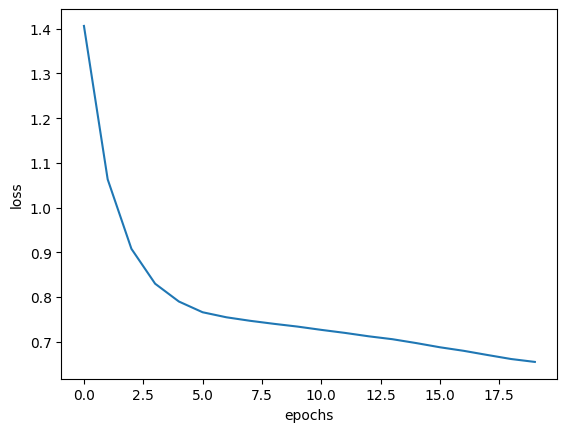

In [ ]:
plt.plot(hst.history['n_loss'])
plt.xlabel('epochs') ; plt.ylabel('loss')

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate/3, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
hist = model.fit(
    train_dataset,
    epochs=num_epochs, batch_size=batch_size,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

Epoch 1/20

nois loss Tensor("Mean:0", shape=(10000, 1), dtype=float32)     img loss Tensor("Mean_1:0", shape=(10000, 1), dtype=float32)

nois loss Tensor("Mean:0", shape=(10000, 1), dtype=float32)     img loss Tensor("Mean_1:0", shape=(10000, 1), dtype=float32)

1/1 [==============================] - ETA: 0s - n_loss: 0.7987

1/1 [==============================] - 69s 69s/step - n_loss: 0.7987

Epoch 2/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7978

1/1 [==============================] - 19s 19s/step - n_loss: 0.7978

Epoch 3/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7978

1/1 [==============================] - 18s 18s/step - n_loss: 0.7978

Epoch 4/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7977

1/1 [==============================] - 18s 18s/step - n_loss: 0.7977

Epoch 5/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7981

1/1 [==============================] - 18s 18s/step - n_loss: 0.7981

Epoch 6/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7984

1/1 [==============================] - 18s 18s/step - n_loss: 0.7984

Epoch 7/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7975

1/1 [==============================] - 18s 18s/step - n_loss: 0.7975

Epoch 8/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7976

1/1 [==============================] - 19s 19s/step - n_loss: 0.7976

Epoch 9/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7977

1/1 [==============================] - 19s 19s/step - n_loss: 0.7977

Epoch 10/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7978

1/1 [==============================] - 18s 18s/step - n_loss: 0.7978

Epoch 11/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7981

1/1 [==============================] - 18s 18s/step - n_loss: 0.7981

Epoch 12/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7968

1/1 [==============================] - 19s 19s/step - n_loss: 0.7968

Epoch 13/20

1/1 [==============================] - ETA: 0s - n_loss: 0.8000

1/1 [==============================] - 18s 18s/step - n_loss: 0.8000

Epoch 14/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7976

1/1 [==============================] - 18s 18s/step - n_loss: 0.7976

Epoch 15/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7984

1/1 [==============================] - 18s 18s/step - n_loss: 0.7984

Epoch 16/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7975

1/1 [==============================] - 18s 18s/step - n_loss: 0.7975

Epoch 17/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7984

1/1 [==============================] - 19s 19s/step - n_loss: 0.7984

Epoch 18/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7976

1/1 [==============================] - 18s 18s/step - n_loss: 0.7976

Epoch 19/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7982

1/1 [==============================] - 18s 18s/step - n_loss: 0.7982

Epoch 20/20

1/1 [==============================] - ETA: 0s - n_loss: 0.7974

1/1 [==============================] - 19s 19s/step - n_loss: 0.7974


In [ ]:
emb_vec= 200; dish_nutri_wdth = 100;

reg = tf.keras.regularizers.L2(0.005)

inp_emb = tf.keras.Input((None,emb_vec))
#inp_noise = tf.keras.Input((None,50))
#inp = tf.keras.layers.concatenate([inp_req, inp_noise])
inp = tf.keras.layers.BatchNormalization()(inp_emb)
x = tf.keras.layers.Dense(600, activation="leaky_relu", kernel_regularizer=reg)(inp)
x= tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(500, activation="leaky_relu", kernel_regularizer=reg)(x)
x= tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(400,activation="leaky_relu", kernel_regularizer=reg)(x)
x= tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(400,activation="leaky_relu", kernel_regularizer=reg)(x)
x= tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(200, activation="leaky_relu", kernel_regularizer=reg)(x)
x= tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.Dense(100, activation="sigmoid")(x)
x1 = tf.expand_dims(inp,axis=-2)
#x1 = tf.keras.layers.Conv1D(10,100,padding="same",activation="relu", kernel_regularizer=reg,input_shape=(None,1,emb_vec))(inp)
#x1 = tf.keras.layers.Dense(200, activation="leaky_relu", kernel_regularizer=reg)(inp)
x1= tf.keras.layers.BatchNormalization()(x1)
scl_10 = tf.keras.layers.Dense(100,activation="softmax")(x1)
scl_50 = tf.keras.layers.Dense(100,activation="softmax")(x1)
scl_100 = tf.keras.layers.Dense(100,activation="softmax")(x1)
scl_700 = tf.keras.layers.Dense(100,activation="softmax")(x1)
scl = scl_10*10 + scl_50*50 + scl_100*100 + scl_700*700
#out = out*scl

gen_dishs = tf.keras.Model(inp_emb,out)
gen_dishs.summary()

Model: "model_9"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_14 (InputLayer)       [(None, None, 200)]       0         

                                                                 

 batch_normalization_48 (Ba  (None, None, 200)         800       

 tchNormalization)                                               

                                                                 

 dense_77 (Dense)            (None, None, 600)         120600    

                                                                 

 batch_normalization_49 (Ba  (None, None, 600)         2400      

 tchNormalization)                                               

                                                                 

 dense_78 (Dense)            (None, None, 500)         300500    

                                                                 

 batch_normalization_50 (Ba  (None, None, 5

In [ ]:
reg = tf.keras.regularizers.L2(0.001)
rq = np.linspace(1,55,100); rq = np.reshape(rq, (-1,1,100))
req = tf.constant(rq);req = tf.cast(req, dtype="float32");#req = tf.reshape(req,shape=(-1,1,100));req = tf.cast(req, dtype="float32"); rq = np.linspace(0.1,55,100)

inp_dsh = tf.keras.Input((None,100))
x1 = inp_dsh - req*0.7
x2 = inp_dsh - req*1.3
x = tf.keras.layers.Concatenate()([x1,x2])
x = tf.keras.layers.Dense(100, activation="relu")(x)
#x = tf.keras.layers.Dense(300, activation="leaky_relu",kernel_regularizer=reg)(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dense(50, activation="leaky_relu",kernel_regularizer=reg)(x)
#x = tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.Dense(1,activation="sigmoid")(x)
discr = tf.keras.Model(inp_dsh,out)
discr.summary()

rq = np.reshape(rq,(100))
x_tr= np.random.randint(low=[rq*8], high=[rq*12],size=(2000,1,100)); x_rand = np.random.randint(0,high=rq*3,size=(1000,1,100)) ; xr= x_rand = np.random.randint(rq*2,high=rq*5,size=(1000,1,100))
x = np.concatenate((x_tr,x_rand,xr),axis=0); x=x/10.0  #x= tf.expand_dims(xx, axis=1);  # x= np.array([x])
print(x.shape)

y_tr= np.ones((x_tr.shape[0],1)); y_rand = np.zeros((2000,1)) ; y= tf.concat([y_tr, y_rand], axis=0);    y= tf.expand_dims(y, axis=1)
y = tf.cast(y, dtype="float32")
print(y.shape)

#discr.save_weights('discrwghts.h5')
#discr.load_weights('discrwghts.h5')
opt = tf.keras.optimizers.Adam(0.0001)
discr.compile(opt, loss= "binary_crossentropy", metrics=["FalseNegatives","Accuracy","TrueNegatives"])
discr.fit(x,y,epochs=5)


Model: "model_5"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_10 (InputLayer)       [(None, None, 100)]          0         []                            

                                                                                                  

 tf.math.subtract_2 (TFOpLa  (None, None, 100)            0         ['input_10[0][0]']            

 mbda)                                                                                            

                                                                                                  

 tf.math.subtract_3 (TFOpLa  (None, None, 100)            0         ['input_10[0][0]']            

 mbda)                                                                                            

                                                                                 

In [ ]:
tf.config.run_functions_eagerly(True)

def fnc(x):
  return model.generate(-1,300,x) ;

discr.trainable = False; model.trainable= False ; train_size=400;

inp = tf.keras.Input((None,emb_vec))
x = gen_dishs(inp) ; print(x)
#x = tf.convert_to_tensor([[[1],[2]],[[4],[3]]])
x = tf.keras.layers.Lambda(fnc)(x,1,True)  ; #print(x)
out = discr(x)

gen_tr = tf.keras.Model(inp, out)
gen_tr.summary()

x_tr = np.random.rand(train_size,1,emb_vec)
y_tr = np.ones((train_size,1))

opt = tf.keras.optimizers.Adam(0.0001)
gen_tr.compile(opt, loss= "binary_crossentropy", metrics=["Accuracy","FalsePositives"])
gen_tr.fit(x_tr,y_tr,epochs=3)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 100), dtype=tf.float32, name=None), name='model_7/dense_72/Sigmoid:0', description="created by layer 'model_7'")



The following Variables were used a Lambda layer's call (lambda_5), but

are not present in its tracked objects:

  <tf.Variable 'dense_35/kernel:0' shape=(100, 300) dtype=float32>

  <tf.Variable 'dense_35/bias:0' shape=(300,) dtype=float32>

  <tf.Variable 'dense_34/kernel:0' shape=(100, 300) dtype=float32>

  <tf.Variable 'dense_34/bias:0' shape=(300,) dtype=float32>

  <tf.Variable 'dense_39/kernel:0' shape=(600, 400) dtype=float32>

  <tf.Variable 'dense_39/bias:0' shape=(400,) dtype=float32>

  <tf.Variable 'batch_normalization_25/gamma:0' shape=(400,) dtype=float32>

  <tf.Variable 'batch_normalization_25/beta:0' shape=(400,) dtype=float32>

  <tf.Variable 'dense_40/kernel:0' shape=(400, 300) dtype=float32>

  <tf.Variable 'dense_40/bias:0' shape=(300,) dtype=float32>

  <tf.Variable 'batch_normalization_26/gamma:0' shape=(300,) dtype=float32>

  <tf.Variable 'batch_normalization_26/beta:0' shape=(300,) dtype=float32>

  <tf.Variable 'dense_41/kernel:0' shape=(300, 300) dtype=f

Model: "model_8"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_13 (InputLayer)       [(None, None, 200)]       0         

                                                                 

 model_7 (Functional)        (None, None, 100)         729400    

                                                                 

 lambda_5 (Lambda)           (10000, None, 100)        0         

                                                                 

 model_5 (Functional)        (None, None, 1)           20201     

                                                                 


Total params: 749601 (2.86 MB)

Trainable params: 725600 (2.77 MB)

Non-trainable params: 24001 (93.75 KB)

_________________________________________________________________

Epoch 1/3

13/13 [==============================] - 496s 38s/step - loss: 22.8118 - Accuracy: 0.0150 - false_positives_3: 0.0000e+00

E

In [ ]:
#metrics
kn_gen=np.zeros((250,2,2,1)); discr_prd=[];  kn_gen_2=[]; discr_prd_2=[]; gen_hist=[]; discr_hist=[]; err=[];
for i in range(100):
#train gen with discr
    discr.trainable = False; train_size=400;

    x_tr = np.random.rand(train_size,1,emb_vec)
    y_tr = np.ones((train_size,1,1))

    opt = tf.keras.optimizers.Adam(0.001/((i%35)/2+1))
    gen_tr.compile(opt, loss= "binary_crossentropy", metrics=["Accuracy","FalsePositives"])
    hist = gen_tr.fit(x_tr,y_tr,epochs=5)
    gen_hist.append(hist)
#plot acc of gen and print predict for random data and real data
    if i%25 == 0:
        xtst = np.random.rand(2,1,emb_vec)
        yprd = gen_dishs.predict(xtst)
        kngen = kn.kneighbors(tf.squeeze(yprd,axis=1))
        print(kngen)
        print(discr.predict(yprd))
        kn_gen[i,:,:,:] = kngen
        discr_prd.append(discr.predict(yprd))
# train discr with gan result
    rnd = np.random.rand(500,1,emb_vec)
    x_rand = gen_dishs.predict(rnd);  y_rand = np.ones((500,1))
    dist_gen, ign = kn.kneighbors(tf.squeeze(x_rand))  ;     print(tf.math.reduce_mean(dist_gen)); err.append(tf.math.reduce_mean(dist_gen))
    x_tr= tf.expand_dims(usda_food, axis=1) ;   y_tr= np.zeros((x_tr.shape[0],1));

    x = np.concatenate((x_tr,x_rand),axis=0);  print(x.shape)
    y= tf.concat([y_tr, y_rand], axis=0);  # y = sclr.fit_transform(y)
    y = tf.expand_dims(y, axis=1) #y= tf.expand_dims(y, axis=1)
#train discr"
    discr.trainable = True
    opt = tf.keras.optimizers.Adam(0.0008/((i/50)+1))
    discr.compile(opt, loss= "mean_absolute_error", metrics=["Accuracy","FalseNegatives"])
    hist = discr.fit(x,y,epochs=5)
    discr_hist.append(hist)
#after discr trainig
    xtst = np.random.rand(2,1,emb_vec)
    yprd = gen_dishs.predict(xtst)
    kngen = kn.kneighbors(tf.squeeze(yprd,axis=1))
    print(kn.kneighbors(tf.squeeze(yprd,axis=1)))
    print(discr.predict(yprd))
    kn_gen_2.append(kngen)
    discr_prd_2.append(discr.predict(yprd))
    plt.plot(err)

Epoch 1/5

13/13 [==============================] - 510s 39s/step - loss: 414.6679 - Accuracy: 0.1450 - false_positives_4: 0.0000e+00

Epoch 2/5

13/13 [==============================] - 505s 39s/step - loss: 127.9874 - Accuracy: 0.5925 - false_positives_4: 0.0000e+00

Epoch 3/5

13/13 [==============================] - 506s 39s/step - loss: 26.7528 - Accuracy: 0.8750 - false_positives_4: 0.0000e+00

Epoch 4/5

13/13 [==============================] - 508s 39s/step - loss: 16.5073 - Accuracy: 0.9375 - false_positives_4: 0.0000e+00

Epoch 5/5

13/13 [==============================] - 511s 39s/step - loss: 13.3015 - Accuracy: 0.9625 - false_positives_4: 0.0000e+00

1/1 [==============================] - 0s 68ms/step

(array([[96.51246537],

       [96.48223377]]), array([[1206],

       [1206]]))

1/1 [==============================] - 0s 51ms/step

[[[4.502200e-15]]



 [[4.548013e-15]]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

  warnings.warn(


1/1 [==============================] - 0s 70ms/step

16/16 [==============================] - 1s 43ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

  warnings.warn(


tf.Tensor(96.48579380165201, shape=(), dtype=float64)

(2500, 1, 100)

Epoch 1/5

79/79 [==============================] - 4s 47ms/step - loss: 0.2758 - Accuracy: 0.7240 - false_negatives_1: 500.0000

Epoch 2/5

79/79 [==============================] - 3s 38ms/step - loss: 0.2048 - Accuracy: 0.7952 - false_negatives_1: 500.0000

Epoch 3/5

79/79 [==============================] - 3s 36ms/step - loss: 0.2000 - Accuracy: 0.8000 - false_negatives_1: 500.0000

Epoch 4/5

79/79 [==============================] - 3s 40ms/step - loss: 0.2000 - Accuracy: 0.8000 - false_negatives_1: 500.0000

Epoch 5/5

79/79 [==============================] - 4s 51ms/step - loss: 0.2000 - Accuracy: 0.8000 - false_negatives_1: 500.0000

1/1 [==============================] - 0s 56ms/step

(array([[96.48813202],

       [96.48964633]]), array([[1206],

       [1206]]))

1/1 [==============================] - 0s 44ms/step

[[[0.]]



 [[0.]]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

  warnings.warn(


1/1 [==============================] - 0s 37ms/step

Epoch 1/5

13/13 [==============================] - 491s 38s/step - loss: 7417.4033 - Accuracy: 0.0000e+00 - false_positives_5: 0.0000e+00

Epoch 2/5

13/13 [==============================] - 484s 37s/step - loss: 3969.9343 - Accuracy: 0.0000e+00 - false_positives_5: 0.0000e+00

Epoch 3/5

13/13 [==============================] - 491s 38s/step - loss: 3101.1987 - Accuracy: 0.0000e+00 - false_positives_5: 0.0000e+00

Epoch 4/5

11/13 [========================>.....] - ETA: 1:15 - loss: 2508.2961 - Accuracy: 0.0000e+00 - false_positives_5: 0.0000e+00

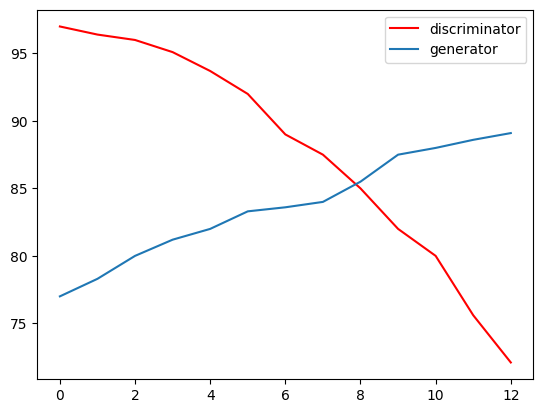

In [ ]:
import matplotlib.pyplot as plt
ls = [48,12,2,1.6,1.3]; acc = [77,78.3,80,81.2,82,83.3,83.6,84,85.5,87.5,88,88.6,89.1]; ds=  [97,96.4,96,95.1,93.7,92,89,87.5,85,82,80,75.6,72.1]
plt.plot(ds,label="discriminator",color="red")
plt.plot(acc, label="generator")
plt.legend()

## Inference

In [ ]:
dsh = model.generate(
            num_images=5,
            diffusion_steps=plot_diffusion_steps,
        )
print(kn.kneighbors(tf.math.abs(tf.squeeze(dsh))))
print(model.generate(num_images=1,diffusion_steps=plot_diffusion_steps))

# load the best model and generate images
#model.load_weights(checkpoint_path)
#model.plot_images()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names

  warnings.warn(


(array([[1414.85238749],

       [1819.81837095],

       [2107.8613584 ],

       [1338.87735882],

       [2030.86574688]]), array([[ 624],

       [ 307],

       [1322],

       [ 821],

       [ 307]]))

tf.Tensor(

[[[-1.97922821e+01 -2.09543869e+02 -1.12613640e+02 -1.62607849e+02

   -2.15722198e+01 -3.63298798e+02 -6.99915266e+00 -1.65396393e+02

   -2.12770386e+01 -1.19084221e+02 -2.44358110e+00 -2.03335602e+02

   -3.02832317e+01 -4.85262642e+01  1.01158432e+02 -7.60228806e+01

   -2.81071106e+02 -5.94388123e+02 -2.57903992e+02 -2.30215927e+02

   -1.13132286e+02 -3.22139160e+02 -2.46647434e+01 -4.66237144e+01

   -2.76962433e+02 -7.81017532e+01  5.87211561e+00 -8.20686417e+01

   -5.65239197e+02  1.99406414e+01 -1.68138779e+02 -8.91571121e+01

   -1.44269699e+02  4.17653618e+01 -1.34213409e+02 -4.83919563e+01

   -7.06533752e+02 -8.77778442e+02  1.44766525e+02 -2.51706787e+02

   -1.45078144e+01 -7.10744019e+02 -6.61145996e+02 -1.51451981e+02

    4.92684031e+00 -4.64580002e

## Results

By running the training for at least 50 epochs (takes 2 hours on a T4 GPU and 30 minutes
on an A100 GPU), one can get high quality image generations using this code example.

The evolution of a batch of images over a 80 epoch training (color artifacts are due to
GIF compression):

![flowers training gif](https://i.imgur.com/FSCKtZq.gif)

Images generated using between 1 and 20 sampling steps from the same initial noise:

![flowers sampling steps gif](https://i.imgur.com/tM5LyH3.gif)

Interpolation (spherical) between initial noise samples:

![flowers interpolation gif](https://i.imgur.com/hk5Hd5o.gif)

Deterministic sampling process (noisy images on top, predicted images on bottom, 40
steps):

![flowers deterministic generation gif](https://i.imgur.com/wCvzynh.gif)

Stochastic sampling process (noisy images on top, predicted images on bottom, 80 steps):

![flowers stochastic generation gif](https://i.imgur.com/kRXOGzd.gif)

Trained model and demo available on HuggingFace:

| Trained Model | Demo |
| :--: | :--: |
| [![model badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-DDIM-black.svg)](https://huggingface.co/keras-io/denoising-diffusion-implicit-models) | [![spaces badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-DDIM-black.svg)](https://huggingface.co/spaces/keras-io/denoising-diffusion-implicit-models) |

## Lessons learned

During preparation for this code example I have run numerous experiments using
[this repository](https://github.com/beresandras/clear-diffusion-keras).
In this section I list
the lessons learned and my recommendations in my subjective order of importance.

### Algorithmic tips

* **min. and max. signal rates**: I found the min. signal rate to be an important
hyperparameter. Setting it too low will make the generated images oversaturated, while
setting it too high will make them undersaturated. I recommend tuning it carefully. Also,
setting it to 0 will lead to a division by zero error. The max. signal rate can be set to
1, but I found that setting it lower slightly improves generation quality.
* **loss function**: While large models tend to use mean squared error (MSE) loss, I
recommend using mean absolute error (MAE) on this dataset. In my experience MSE loss
generates more diverse samples (it also seems to hallucinate more
[Section 3](https://arxiv.org/abs/2111.05826)), while MAE loss leads to smoother images.
I recommend trying both.
* **weight decay**: I did occasionally run into diverged trainings when scaling up the
model, and found that weight decay helps in avoiding instabilities at a low performance
cost. This is why I use
[AdamW](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/AdamW)
instead of [Adam](https://keras.io/api/optimizers/adam/) in this example.
* **exponential moving average of weights**: This helps to reduce the variance of the KID
metric, and helps in averaging out short-term changes during training.
* **image augmentations**: Though I did not use image augmentations in this example, in
my experience adding horizontal flips to the training increases generation performance,
while random crops do not. Since we use a supervised denoising loss, overfitting can be
an issue, so image augmentations might be important on small datasets. One should also be
careful not to use
[leaky augmentations](https://keras.io/examples/generative/gan_ada/#invertible-data-augmentation),
which can be done following
[this method (end of Section 5)](https://arxiv.org/abs/2206.00364) for instance.
* **data normalization**: In the literature the pixel values of images are usually
converted to the -1 to 1 range. For theoretical correctness, I normalize the images to
have zero mean and unit variance instead, exactly like the random noises.
* **noise level input**: I chose to input the noise variance to the network, as it is
symmetrical under our sampling schedule. One could also input the noise rate (similar
performance), the signal rate (lower performance), or even the
[log-signal-to-noise ratio (Appendix B.1)](https://arxiv.org/abs/2107.00630)
(did not try, as its range is highly
dependent on the min. and max. signal rates, and would require adjusting the min.
embedding frequency accordingly).
* **gradient clipping**: Using global gradient clipping with a value of 1 can help with
training stability for large models, but decreased performance significantly in my
experience.
* **residual connection downscaling**: For
[deeper models (Appendix B)](https://arxiv.org/abs/2205.11487), scaling the residual
connections with 1/sqrt(2) can be helpful, but did not help in my case.
* **learning rate**: For me, [Adam optimizer's](https://keras.io/api/optimizers/adam/)
default learning rate of 1e-3 worked very well, but lower learning rates are more common
in the [literature (Tables 11-13)](https://arxiv.org/abs/2105.05233).

### Architectural tips

* **sinusoidal embedding**: Using sinusoidal embeddings on the noise level input of the
network is crucial for good performance. I recommend setting the min. embedding frequency
to the reciprocal of the range of this input, and since we use the noise variance in this
example, it can be left always at 1. The max. embedding frequency controls the smallest
change in the noise variance that the network will be sensitive to, and the embedding
dimensions set the number of frequency components in the embedding. In my experience the
performance is not too sensitive to these values.
* **skip connections**: Using skip connections in the network architecture is absolutely
critical, without them the model will fail to learn to denoise at a good performance.
* **residual connections**: In my experience residual connections also significantly
improve performance, but this might be due to the fact that we only input the noise
level embeddings to the first layer of the network instead of to all of them.
* **normalization**: When scaling up the model, I did occasionally encounter diverged
trainings, using normalization layers helped to mitigate this issue. In the literature it
is common to use
[GroupNormalization](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/GroupNormalization)
(with 8 groups for example) or
[LayerNormalization](https://keras.io/api/layers/normalization_layers/layer_normalization/)
in the network, I however chose to use
[BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/),
as it gave similar benefits in my experiments but was computationally lighter.
* **activations**: The choice of activation functions had a larger effect on generation
quality than I expected. In my experiments using non-monotonic activation functions
outperformed monotonic ones (such as
[ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)), with
[Swish](https://www.tensorflow.org/api_docs/python/tf/keras/activations/swish) performing
the best (this is also what [Imagen uses, page 41](https://arxiv.org/abs/2205.11487)).
* **attention**: As mentioned earlier, it is common in the literature to use
[attention layers](https://keras.io/api/layers/attention_layers/multi_head_attention/) at low
resolutions for better global coherence. I omitted them for simplicity.
* **upsampling**:
[Bilinear and nearest neighbour upsampling](https://keras.io/api/layers/reshaping_layers/up_sampling2d/)
in the network performed similarly, however I did not try
[transposed convolutions](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/).

For a similar list about GANs check out
[this Keras tutorial](https://keras.io/examples/generative/gan_ada/#gan-tips-and-tricks).

## What to try next?

If you would like to dive in deeper to the topic, I recommend checking out
[this repository](https://github.com/beresandras/clear-diffusion-keras) that I created in
preparation for this code example, which implements a wider range of features in a
similar style, such as:

* stochastic sampling
* second-order sampling based on the
[differential equation view of DDIMs (Equation 13)](https://arxiv.org/abs/2010.02502)
* more diffusion schedules
* more network output types: predicting image or
[velocity (Appendix D)](https://arxiv.org/abs/2202.00512) instead of noise
* more datasets

## Related works

* [Score-based generative modeling](https://yang-song.github.io/blog/2021/score/)
(blogpost)
* [What are diffusion models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
(blogpost)
* [Annotated diffusion model](https://huggingface.co/blog/annotated-diffusion) (blogpost)
* [CVPR 2022 tutorial on diffusion models](https://cvpr2022-tutorial-diffusion-models.github.io/)
(slides available)
* [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364):
attempts unifying diffusion methods under a common framework
* High-level video overviews: [1](https://www.youtube.com/watch?v=yTAMrHVG1ew),
[2](https://www.youtube.com/watch?v=344w5h24-h8)
* Detailed technical videos: [1](https://www.youtube.com/watch?v=fbLgFrlTnGU),
[2](https://www.youtube.com/watch?v=W-O7AZNzbzQ)
* Score-based generative models: [NCSN](https://arxiv.org/abs/1907.05600),
[NCSN+](https://arxiv.org/abs/2006.09011), [NCSN++](https://arxiv.org/abs/2011.13456)
* Denoising diffusion models: [DDPM](https://arxiv.org/abs/2006.11239),
[DDIM](https://arxiv.org/abs/2010.02502), [DDPM+](https://arxiv.org/abs/2102.09672),
[DDPM++](https://arxiv.org/abs/2105.05233)
* Large diffusion models: [GLIDE](https://arxiv.org/abs/2112.10741),
[DALL-E 2](https://arxiv.org/abs/2204.06125/), [Imagen](https://arxiv.org/abs/2205.11487)
